## Imports and data Load


In [36]:
import nltk
from nltk.corpus import wordnet as wn
from pathlib import Path
import pandas as pd
import math


debugMode = True

In [37]:
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Similarity of Concepts

In the initial section, we utilize two lexical resources to tackle the task of **concept similarity**. These resources comprise:

- Wordnet, employing the provided APIs from NLTK.
- WordSim353, a corpus that encompasses a collection of triplets (word1, word2, similarity value).

The primary aim of this segment is to construct three distinct measures of similarity grounded in the taxonomic framework of Wordnet

### Measure 1 : Wu Palmer Similarity

$$ \operatorname{sim}(s1,s2) = \frac{2\cdot\operatorname{depth}(LCS(s1,s2))}{\operatorname{depth}(s1) + \operatorname{depth}(s2)} $$

$LCS(s1,s2)$ denotes the _Lowest Common Subsumer_, signifying the **closest shared** synset to synsets $s1$ and $s2$ within the hierarchy of hypernyms/hyponyms. $\operatorname{depth}(s)$ represents the depth (minimum distance) of synset $s$ from the root.


In [38]:
# I have considered to ways to handle the LCS problem:
# 1. The first one is to use the hypernym_paths function to obtain all hypernym paths of a synset (any path), then select the one where the two synsets meet for the first time and looking for the hypernym with the highest max_depth
# 2. The second one is to use the common_hypernyms function to obtain the common hypernyms of two synsets, then select the one with the highest max_depth (as suggested in the course lesson)

def lowest_common_subsumer(synset1, synset2):
    def hypernym_paths(synset):
        # Helper function to obtain all hypernym paths of a synset
        paths = [[synset]]  # Initialize with the synset as the starting point
        hypernyms = synset.hypernyms()
        if hypernyms:
            for hypernym in hypernyms:
                subpaths = hypernym_paths(hypernym)
                paths.extend([path + [hypernym] for path in subpaths])
        return paths

    paths1 = hypernym_paths(synset1)
    paths2 = hypernym_paths(synset2)
    common_hypernym = None
    max_depth = -1

    for path1 in paths1:
        for path2 in paths2:
            for i in range(min(len(path1), len(path2))):
                if path1[i] == path2[i]:
                    common_hypernym = path1[i]
                    max_depth = i
                else:
                    break  # No need to continue searching if a mismatch is found
            if max_depth >= 0:
                break  # No need to continue searching if a common hypernym is found
        if max_depth >= 0:
            break  # No need to continue searching if a common hypernym is found

    return common_hypernym


def get_lowest_common_hypernym(synset1, synset2):
    # https://www.nltk.org/api/nltk.corpus.reader.wordnet.html#nltk.corpus.reader.wordnet.Synset.common_hypernyms
    common_hypernyms = synset1.common_hypernyms(synset2)
    if common_hypernyms:
        return max(common_hypernyms, key=lambda synset: synset.max_depth())
    return None


if debugMode:
    word1 = 'king'
    word2 = 'cabbage'
    pos = 'n'
    syn1 = wn.synsets(word1, pos)
    syn2 = wn.synsets(word2, pos)
    # loop between all synsets of word1 and word2 and execute the function lowest_common_subsumer
    for s1 in syn1:
        for s2 in syn2:
            print(s1, s2, lowest_common_subsumer(s1, s2))
            print(s1, s2, get_lowest_common_hypernym(s1, s2))

            print(s1, s2, s1.lowest_common_hypernyms(s2))
            print("---------------------------------")


Synset('king.n.01') Synset('cabbage.n.01') Synset('physical_entity.n.01')
Synset('king.n.01') Synset('cabbage.n.01') Synset('physical_entity.n.01')
Synset('king.n.01') Synset('cabbage.n.01') [Synset('physical_entity.n.01')]
---------------------------------
Synset('king.n.01') Synset('boodle.n.01') Synset('entity.n.01')
Synset('king.n.01') Synset('boodle.n.01') Synset('entity.n.01')
Synset('king.n.01') Synset('boodle.n.01') [Synset('entity.n.01')]
---------------------------------
Synset('king.n.01') Synset('cabbage.n.03') Synset('physical_entity.n.01')
Synset('king.n.01') Synset('cabbage.n.03') Synset('organism.n.01')
Synset('king.n.01') Synset('cabbage.n.03') [Synset('organism.n.01')]
---------------------------------
Synset('king.n.02') Synset('cabbage.n.01') Synset('physical_entity.n.01')
Synset('king.n.02') Synset('cabbage.n.01') Synset('physical_entity.n.01')
Synset('king.n.02') Synset('cabbage.n.01') [Synset('physical_entity.n.01')]
---------------------------------
Synset('king

**Note**: Regarding the 'wu_palmer function implementation', initially I assumed that the "depth" function had to retrieve the length of the minimum / maximum path from the Wordnet root to the considered synset. Since the NLTK API   "wup_similarity" was returning different results, I have found out that the NLTK implementation defines the "depth" function as the "shortest path from the considered synset to the lcs node". (Then adds to the depth of the lcs)

In [39]:
def nltk_wu_palmer_similarity(synset1, synset2):
    # NLTK implementation
    subsumers = synset1.lowest_common_hypernyms(
        synset2, use_min_depth=True
    )
    # If no LCS was found return None
    if len(subsumers) == 0:
        return None
    subsumer =  subsumers[0]
    depth = subsumer.max_depth() + 1

    len1 = synset1.shortest_path_distance(
        subsumer
    )
    
    len2 = synset2.shortest_path_distance(
        subsumer
    )
    if len1 is None or len2 is None:
        return None
    len1 += depth
    len2 += depth

    return (2.0 * depth) / (len1 + len2)

def cwu_palmer_similarity(synset1, synset2):

    lcs = lowest_common_subsumer(synset1, synset2)
    if lcs is None:
        return 0.0
 
    depth_lcs = lcs.max_depth() + 1
    depth_synset1 = synset1.min_depth() + 1
    depth_synset2 = synset2.min_depth() + 1
    similarity = (2.0 * depth_lcs) / (depth_synset1 + depth_synset2)
    return similarity

def wu_palmer_similarity(synset1, synset2,normalize=False):

    lcs = lowest_common_subsumer(synset1, synset2)
    if lcs is None:
        return 0.0
 
    depth_lcs = lcs.max_depth() + 1
    depth_synset1 = synset1.shortest_path_distance(
        lcs
    )
    
    depth_synset2 = synset2.shortest_path_distance(
        lcs
    )
    depth_synset1+= depth_lcs
    depth_synset2+= depth_lcs
    
    similarity = (2.0 * depth_lcs) / (depth_synset1 + depth_synset2)
    
    if(normalize):
        # it is already normalized 
        pass
    return similarity  


if debugMode:
    word1='king'
    word2= 'cabbage'
    pos = 'n'
    syn1 = wn.synsets(word1, pos) 
    syn2 = wn.synsets(word2, pos)
    # loop between all synsets of word1 and word2 and execute the function lowest_common_subsumer
    for s1 in syn1:
        for s2 in syn2:
            print(s1.name(),'\n', s2.name())
            print(nltk_wu_palmer_similarity(s1, s2))
            print(wu_palmer_similarity(s1, s2))
            print( s1.wup_similarity(s2))
            print("---------------------------------")   


king.n.01 
 cabbage.n.01
0.25
0.25
0.25
---------------------------------
king.n.01 
 boodle.n.01
0.13333333333333333
0.13333333333333333
0.13333333333333333
---------------------------------
king.n.01 
 cabbage.n.03
0.5714285714285714
0.2222222222222222
0.5714285714285714
---------------------------------
king.n.02 
 cabbage.n.01
0.25
0.25
0.25
---------------------------------
king.n.02 
 boodle.n.01
0.13333333333333333
0.13333333333333333
0.13333333333333333
---------------------------------
king.n.02 
 cabbage.n.03
0.5714285714285714
0.2222222222222222
0.5714285714285714
---------------------------------
baron.n.03 
 cabbage.n.01
0.23529411764705882
0.23529411764705882
0.23529411764705882
---------------------------------
baron.n.03 
 boodle.n.01
0.125
0.125
0.125
---------------------------------
baron.n.03 
 cabbage.n.03
0.5454545454545454
0.21052631578947367
0.5454545454545454
---------------------------------
king.n.04 
 cabbage.n.01
0.11764705882352941
0.11764705882352941
0.11

### Measure 2 : Shortest Path Similarity


$$ \operatorname{sim}(s1,s2) = 2\cdot\operatorname{depthMax} - \operatorname{len}(s1,s2) $$

**Shortest Path Similarity**

For a specific version of WordNet, the value of `depthMax` remains fixed. In WordNet, the hierarchy is partitioned based on four POS tags: noun, verb, adjective, and adverb. Each POS tag has its own hierarchy, and therefore, the value of depthMax can vary depending on the particular POS being considered.

The similarity between two senses (`s1`, `s2`) is determined by the shortest path, `len(s1, s2)`, from `s1` to `s2`. The following rules apply:

- If `len(s1, s2)` is 0, `simpath(s1, s2)` is assigned the maximum value of `2 * depthMax`.
- If `len(s1, s2)` is `2 * depthMax`, `simpath(s1, s2)` is assigned the minimum value of 0.
- Therefore, the values of `simpath(s1, s2)` lie between 0 and `2 * depthMax`.


In [40]:
def calculate_pos_max_depths():
    pos_max_depths = {}
    pos_tags = ['n', 'v', 'a', 'r']  # Noun, verb, adjective, adverb
    
    for pos_tag in pos_tags:
        synsets = wn.all_synsets(pos=pos_tag)
        max_depth = max(synset.max_depth() for synset in synsets)
        pos_max_depths[pos_tag] = max_depth
    
    return pos_max_depths


pos_max_depths = calculate_pos_max_depths()

def depthMax(synset):
    return pos_max_depths[synset._pos]


def shortest_path_similarity(s1, s2,normalize= False):
    # https://www.nltk.org/api/nltk.corpus.reader.wordnet.html#nltk.corpus.reader.wordnet.Synset.shortest_path_distance
    # Calculate the shortest path length between s1 and s2
    shortest_path_len = (s1.shortest_path_distance(s2)) + 1
    # Calculate the maximum depth of the WordNet hierarchy
    depth_Max = depthMax(s1)
    if shortest_path_len == 0:
        similarity = 2 * depth_Max  # Maximum similarity when the shortest path length is 0

    if shortest_path_len == 2 * depth_Max:
        similarity = 0  # Minimum similarity when the shortest path length is 2 * depthMax

    # Calculate the similarity using the formula
    similarity = 2 * depth_Max - shortest_path_len
    
    if(normalize):
        similarity /= (2 * depth_Max)

    return similarity


if  debugMode:
    word1 = 'love'
    word2 = 'sex'
    pos = 'n'
    syn1 = wn.synsets(word1, pos)
    syn2 = wn.synsets(word2, pos)
    # loop between all synsets of word1 and word2 and execute the function lowest_common_subsumer
    for s1 in syn1:
        for s2 in syn2:
            print(s1.name(), '\t', s2.name())
            print(shortest_path_similarity(s1, s2))
            print(shortest_path_similarity(s1, s2,True))
            print(s1.path_similarity(s2))
            print("---------------------------------")




love.n.01 	 sexual_activity.n.01
26
0.6842105263157895
0.08333333333333333
---------------------------------
love.n.01 	 sex.n.02
28
0.7368421052631579
0.1
---------------------------------
love.n.01 	 sex.n.03
34
0.8947368421052632
0.25
---------------------------------
love.n.01 	 sex.n.04
29
0.7631578947368421
0.1111111111111111
---------------------------------
love.n.02 	 sexual_activity.n.01
26
0.6842105263157895
0.08333333333333333
---------------------------------
love.n.02 	 sex.n.02
28
0.7368421052631579
0.1
---------------------------------
love.n.02 	 sex.n.03
28
0.7368421052631579
0.1
---------------------------------
love.n.02 	 sex.n.04
27
0.7105263157894737
0.09090909090909091
---------------------------------
beloved.n.01 	 sexual_activity.n.01
29
0.7631578947368421
0.1111111111111111
---------------------------------
beloved.n.01 	 sex.n.02
27
0.7105263157894737
0.09090909090909091
---------------------------------
beloved.n.01 	 sex.n.03
27
0.7105263157894737
0.09090

### Measure 3 : Leakcock-Chodorow Similarity

$$ \operatorname{sim}(s1,s2) = -\log\frac{\operatorname{len}(s1,s2)}{2\cdot\operatorname{depthMax}} $$

When s1 and s2 have the same sense (len(s1, s2) = 0), adding 1 to both len(s1, s2) and 2 _ depthMax avoids taking the logarithm of 0. The resulting similarity values from simLC(s1, s2) fall in the interval (0, log(2 _ depthMax + 1)].


In [41]:



def leakcock_chodorow_similarity(synset1, synset2,normalize=False):
    max_depth = depthMax(synset1)
    # https://www.nltk.org/api/nltk.corpus.reader.wordnet.html#nltk.corpus.reader.wordnet.Synset.shortest_path_distance
    dist = synset1.shortest_path_distance(synset2)
    if dist is None:
        similarity = 0
    else:
        similarity = -math.log((dist+1)/(2*max_depth))
    if(normalize):
        similarity = (similarity + math.log(2)) / (math.log(2 * max_depth) + math.log(2))

    return similarity


if  debugMode:
    word1 = 'love'
    word2 = 'sex'
    pos = 'n'
    syn1 = wn.synsets(word1, pos)
    syn2 = wn.synsets(word2, pos)
    # loop between all synsets of word1 and word2 and execute the function lowest_common_subsumer
    for s1 in syn1:
        for s2 in syn2:
            print(s1.name(), '\n', s2.name())
            print(leakcock_chodorow_similarity(s1, s2))
            print(wn.lch_similarity(s1, s2)) # nltk implementation test
            print("---------------------------------")


love.n.01 
 sexual_activity.n.01
1.1526795099383855
1.1526795099383855
---------------------------------
love.n.01 
 sex.n.02
1.3350010667323402
1.3350010667323402
---------------------------------
love.n.01 
 sex.n.03
2.2512917986064953
2.2512917986064953
---------------------------------
love.n.01 
 sex.n.04
1.4403615823901665
1.4403615823901665
---------------------------------
love.n.02 
 sexual_activity.n.01
1.1526795099383855
1.1526795099383855
---------------------------------
love.n.02 
 sex.n.02
1.3350010667323402
1.3350010667323402
---------------------------------
love.n.02 
 sex.n.03
1.3350010667323402
1.3350010667323402
---------------------------------
love.n.02 
 sex.n.04
1.2396908869280152
1.2396908869280152
---------------------------------
beloved.n.01 
 sexual_activity.n.01
1.4403615823901665
1.4403615823901665
---------------------------------
beloved.n.01 
 sex.n.02
1.2396908869280152
1.2396908869280152
---------------------------------
beloved.n.01 
 sex.n.03
1.23

## Word Similarity 

In the context of computing similarity between terms (words) using senses, there are a few considerations:

1. Input: The input consists of pairs of terms (words), not synsets (senses). We need to derive the synsets associated with the terms to perform the similarity calculation.

2. Maximum Similarity: To compute the similarity between two terms, we consider the maximum similarity among all pairs of senses: one sense from the first term and one sense from the second term.

3. Context of Disambiguation: The assumption is that the two terms serve as a context for disambiguation for each other. By considering all possible sense combinations, we aim to find the most similar senses that align with each term's intended meaning within the given context.

4. Formula: The formula calculates the similarity between two terms (w1 and w2) by taking the maximum similarity among all pairs of associated synsets (c1 and c2). The similarity between each pair of synsets (sim(c1, c2)) is used for comparison.

$$ \operatorname{sim}(w_1, w_2) = \operatorname*{max}_{\substack{c_1 \in \operatorname{Syn}(w_1)\\ c_2 \in \operatorname{Syn}(w_2) }} \operatorname{sim}(c_1,c_2)$$


In [42]:
def word_similarity(word1, word2, similarity_func, normalize=False, pos='n'):
    """
    Compute the concept similarity as maximum among 
    all possible pair of senses of the given words.
    """
    similarities = [similarity_func(s1, s2, normalize) for s1 in wn.synsets(
        word1, pos) for s2 in wn.synsets(word2, pos)]
    if all(sim == None for sim in similarities):
        cs = None
    else:
        cs = max(sim for sim in similarities if sim is not None)
    return cs

def eval_similarity(row,normalize=False):
    wup = word_similarity(
        row['word1'], row['word2'], wu_palmer_similarity,normalize, 'n')

    path = word_similarity(
        row['word1'], row['word2'], shortest_path_similarity,normalize, 'n')

    leak = word_similarity(
        row['word1'], row['word2'], leakcock_chodorow_similarity,normalize, 'n')

    return pd.Series([wup, path, leak])

if  debugMode:
    word1 = 'king'
    word2 = 'cabbage'
    pos = 'n'
    print(eval_similarity({"word1":word1,"word2":word2},pos))

0    0.363636
1    0.736842
2    0.468315
dtype: float64


#### Evaluation over the dataset  



In [43]:
word_sim = pd.read_csv(Path('.') / "data" / "WordSim353.csv")
word_sim.columns = ['word1', 'word2', 'gold_score']

# Apply the eval_similarity function to the dataframe
word_sim[['wup', 'path', 'leak']] = word_sim.apply(eval_similarity, axis=1)

# Print the first 10 random rows of the dataframe
print(word_sim.sample(10))



         word1       word2  gold_score       wup  path      leak
14      doctor       nurse        7.00  0.869565  34.0  2.251292
280       game        team        7.69  0.307692  28.0  1.335001
163       news      report        8.16  0.923077  36.0  2.944439
346  admission      ticket        7.69  0.571429  31.0  1.691676
86       coast        hill        4.38  0.666667  33.0  2.028148
2        tiger       tiger       10.00  1.000000  37.0  3.637586
341       rock        jazz        7.59  0.875000  35.0  2.538974
112      tiger    organism        4.77  0.571429  35.0  2.538974
281   marathon      sprint        7.47  0.500000  27.0  1.239691
104      money  withdrawal        6.88  0.285714  27.0  1.239691


In [44]:
from scipy.stats import spearmanr, pearsonr

# clean data
import numpy as np

# Remove NaN and Inf values from the arrays
word_sim['gold_score']= word_sim['gold_score'].replace([np.inf, -np.inf, np.nan], 0)
word_sim['wup']= word_sim['wup'].replace([np.inf, -np.inf, np.nan],0)
word_sim['path']= word_sim['path'].replace([np.inf, -np.inf, np.nan],0)
word_sim['leak']= word_sim['leak'].replace([np.inf, -np.inf, np.nan],0)


# # evaluate pearson correlation index between the gold_score and the similarity scores
# #Pearson
print("####################################################################")
print("Pearson ")
print(pearsonr(word_sim['gold_score'].values, word_sim['wup'].values))
print(pearsonr(word_sim['gold_score'].values, word_sim['path'].values))
print(pearsonr(word_sim['gold_score'].values, word_sim['leak'].values))
print("\n")
print(word_sim[['gold_score', 'wup', 'path', 'leak']].corr(method='pearson'))
print("\n")

# evaluate spearman correlation index between the gold_score and the similarity scores
#Spearman
print("Spearman ")
print(spearmanr(word_sim['gold_score'], word_sim['wup']))
print(spearmanr(word_sim['gold_score'], word_sim['path']))
print(spearmanr(word_sim['gold_score'], word_sim['leak']))
print("\n")
print(word_sim[['gold_score', 'wup', 'path', 'leak']].corr(method='spearman'))




####################################################################
Pearson 
PearsonRResult(statistic=0.26881693990150124, pvalue=2.937998535643503e-07)
PearsonRResult(statistic=0.15116745336022439, pvalue=0.004420548547013002)
PearsonRResult(statistic=0.31343239433802383, pvalue=1.7404711932236666e-09)


            gold_score       wup      path      leak
gold_score    1.000000  0.268817  0.151167  0.313432
wup           0.268817  1.000000  0.783341  0.873899
path          0.151167  0.783341  1.000000  0.866603
leak          0.313432  0.873899  0.866603  1.000000


Spearman 
SignificanceResult(statistic=0.3185277703503239, pvalue=9.148785783123704e-10)
SignificanceResult(statistic=0.2956286333641579, pvalue=1.4988058239296277e-08)
SignificanceResult(statistic=0.2956286333641579, pvalue=1.4988058239296277e-08)


            gold_score       wup      path      leak
gold_score    1.000000  0.318528  0.295629  0.295629
wup           0.318528  1.000000  0.913144  0.913144
path          0

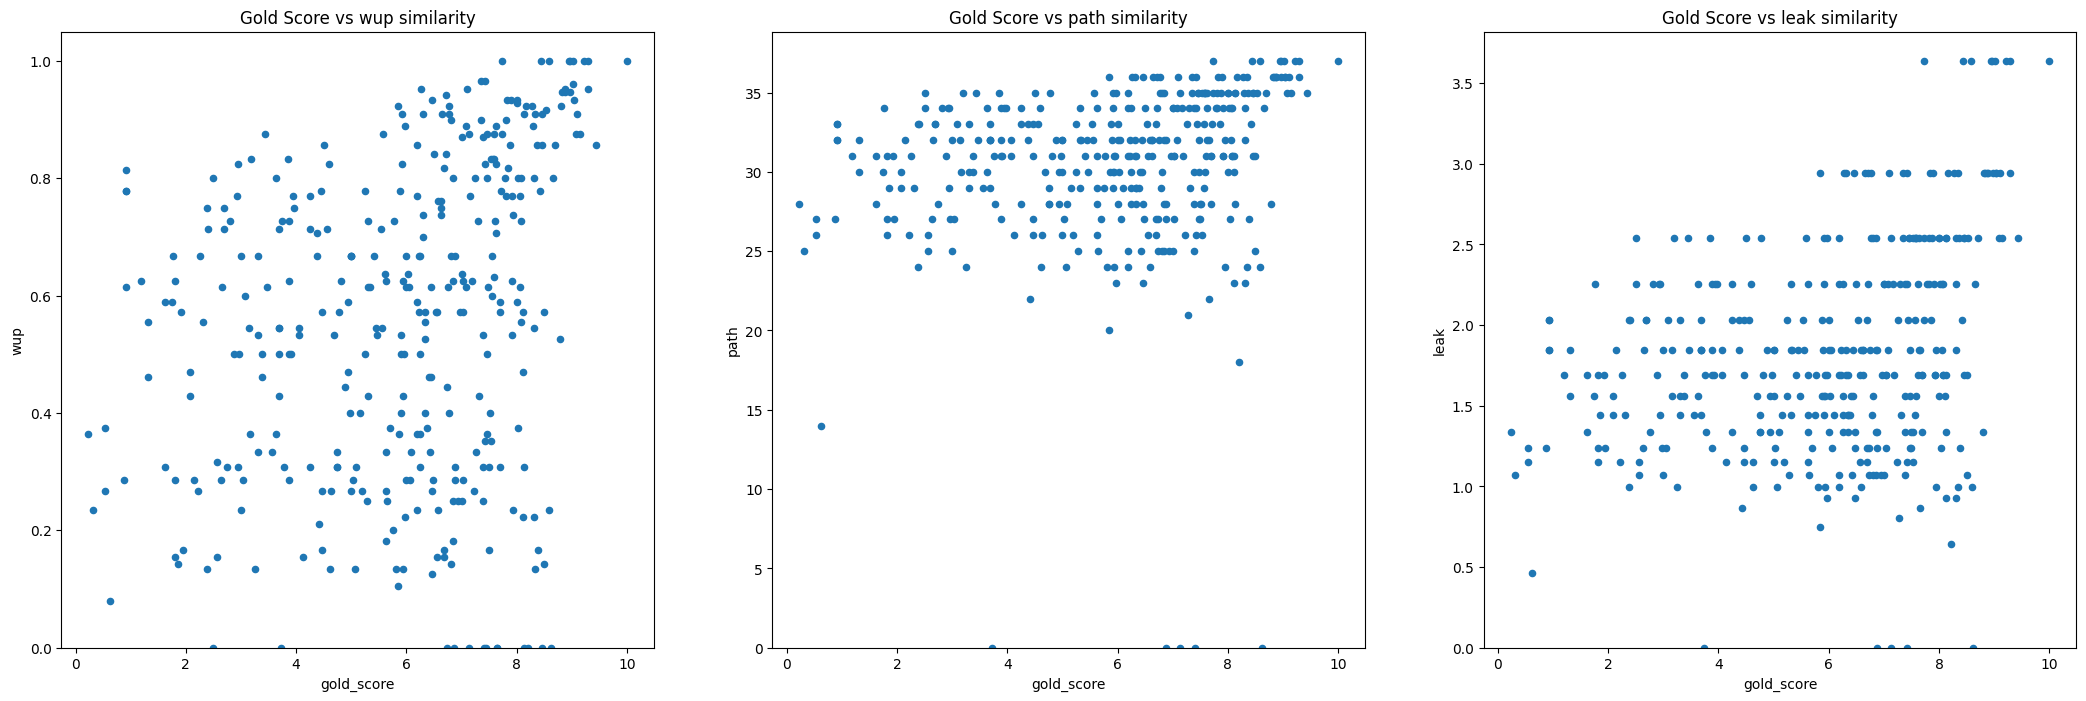

In [45]:
from matplotlib import pyplot as plt


metrics = ['wup', 
           'path',
           'leak']
    
fig, axes = plt.subplots(1,3,figsize=(26,8))
for ax, metric_name in zip(axes, metrics):
    #ax.scatter(x=wordsim_df['gold_score'], y=wordsim_df[metric_name])
    word_sim.plot.scatter(x='gold_score', y=metric_name, ax=ax)
    ax.set_ylim(bottom=0.0)
    ax.set_title("Gold Score vs {} similarity".format(metric_name.replace('_',' ')))

In [49]:
word_sim = pd.read_csv(Path('.') / "data" / "WordSim353.csv")
word_sim.columns = ['word1', 'word2', 'gold_score']
# normalize the gold score between 0 and 1, by dividing by the maximum score
word_sim['gold_score'] /= word_sim['gold_score'].max()

# Apply the eval_similarity function to the dataframe
word_sim[['wup', 'path', 'leak']] = word_sim.apply(eval_similarity, axis=1,normalize=True)

# Print the first 10 random rows of the dataframe
print(word_sim.sample(10))

          word1           word2  gold_score       wup      path      leak
19      company           stock       0.708  0.615385  0.842105  0.586269
150         cup          liquid       0.590  0.400000  0.842105  0.586269
226    consumer          energy       0.475  0.307692  0.736842  0.468315
15    professor          doctor       0.662  0.750000  0.815789  0.550674
119  psychology          clinic       0.658  0.235294  0.631579  0.390621
42     football          soccer       0.903  0.960000  0.947368  0.839947
230      credit     information       0.531  0.727273  0.894737  0.679894
65        drink          mother       0.265  0.615385  0.842105  0.586269
83         monk          oracle       0.500  0.666667  0.789474  0.519841
210    hospital  infrastructure       0.463  0.266667  0.684211  0.426216


In [50]:
from scipy.stats import spearmanr, pearsonr

# clean data
import numpy as np

# Remove NaN and Inf values from the arrays
word_sim['gold_score']= word_sim['gold_score'].replace([np.inf, -np.inf, np.nan], 0)
word_sim['wup']= word_sim['wup'].replace([np.inf, -np.inf, np.nan],0)
word_sim['path']= word_sim['path'].replace([np.inf, -np.inf, np.nan],0)
word_sim['leak']= word_sim['leak'].replace([np.inf, -np.inf, np.nan],0)


# # evaluate pearson correlation index between the gold_score and the similarity scores
# #Pearson
print("####################################################################")
print("Pearson ")
print(pearsonr(word_sim['gold_score'].values, word_sim['wup'].values))
print(pearsonr(word_sim['gold_score'].values, word_sim['path'].values))
print(pearsonr(word_sim['gold_score'].values, word_sim['leak'].values))
print("\n")
print(word_sim[['gold_score', 'wup', 'path', 'leak']].corr(method='pearson'))
print("\n")

# evaluate spearman correlation index between the gold_score and the similarity scores
#Spearman
print("Spearman ")
print(spearmanr(word_sim['gold_score'], word_sim['wup']))
print(spearmanr(word_sim['gold_score'], word_sim['path']))
print(spearmanr(word_sim['gold_score'], word_sim['leak']))
print("\n")
print(word_sim[['gold_score', 'wup', 'path', 'leak']].corr(method='spearman'))




####################################################################
Pearson 
PearsonRResult(statistic=0.2688169399015013, pvalue=2.937998535643503e-07)
PearsonRResult(statistic=0.1511674533602244, pvalue=0.004420548547013002)
PearsonRResult(statistic=0.29331975081482414, pvalue=1.9608277351195224e-08)


            gold_score       wup      path      leak
gold_score    1.000000  0.268817  0.151167  0.293320
wup           0.268817  1.000000  0.783341  0.863575
path          0.151167  0.783341  1.000000  0.909141
leak          0.293320  0.863575  0.909141  1.000000


Spearman 
SignificanceResult(statistic=0.3185277703503239, pvalue=9.148785783123704e-10)
SignificanceResult(statistic=0.2956286333641579, pvalue=1.4988058239296277e-08)
SignificanceResult(statistic=0.2956286333641579, pvalue=1.4988058239296277e-08)


            gold_score       wup      path      leak
gold_score    1.000000  0.318528  0.295629  0.295629
wup           0.318528  1.000000  0.913144  0.913144
path          0.2

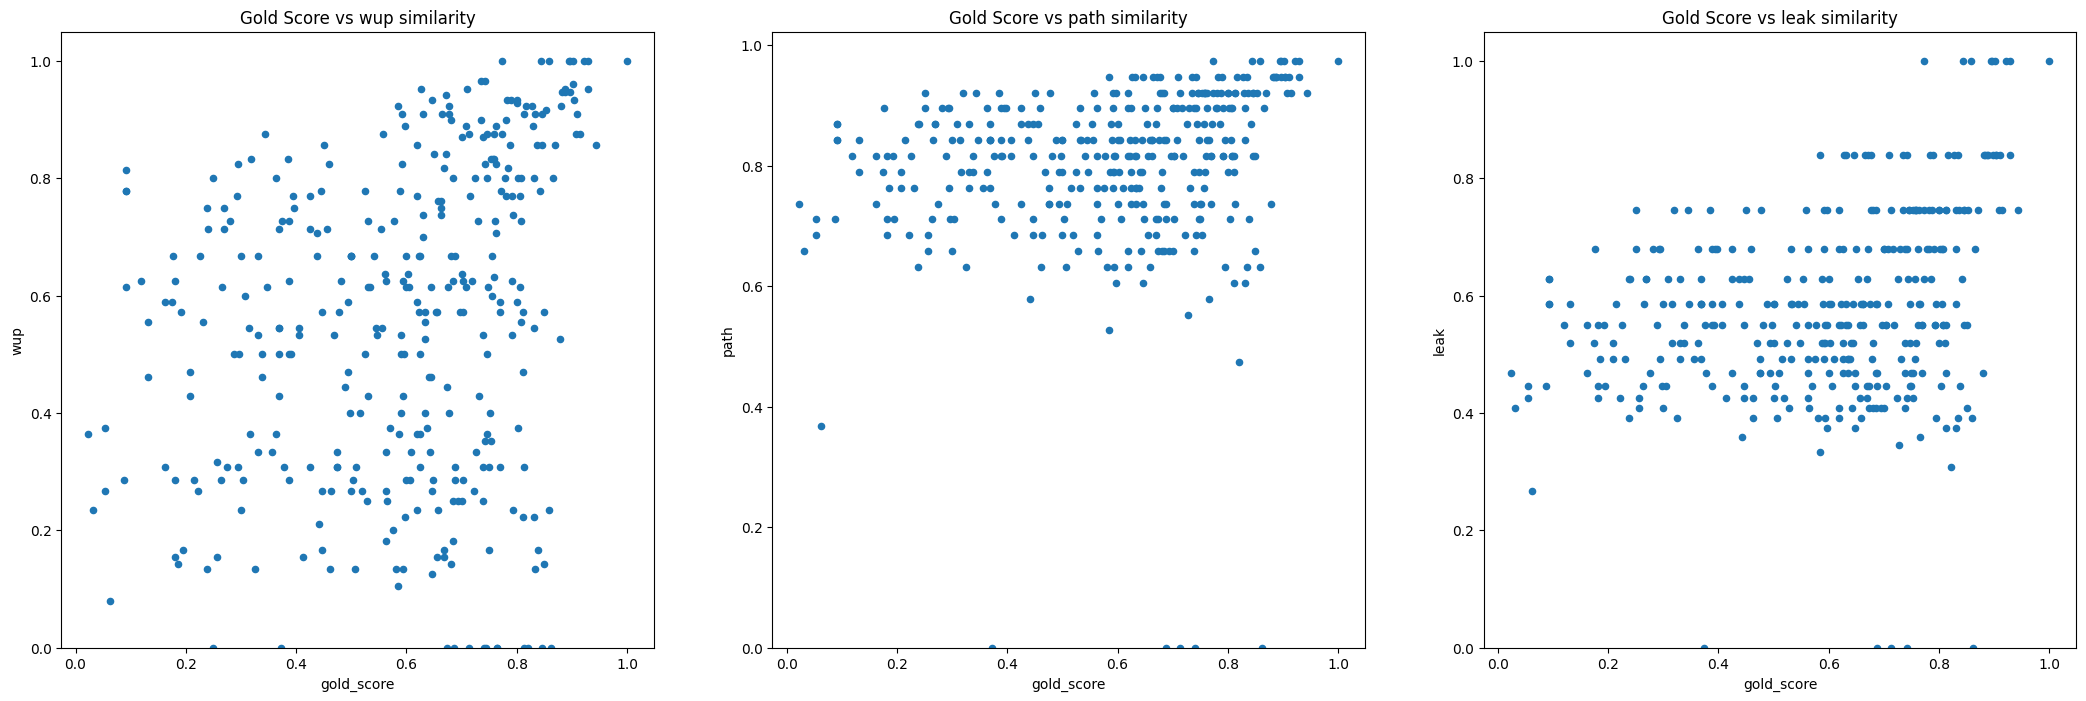

In [51]:
from matplotlib import pyplot as plt


metrics = ['wup', 
           'path',
           'leak']
    
fig, axes = plt.subplots(1,3,figsize=(26,8))
for ax, metric_name in zip(axes, metrics):
    #ax.scatter(x=wordsim_df['gold_score'], y=wordsim_df[metric_name])
    word_sim.plot.scatter(x='gold_score', y=metric_name, ax=ax)
    ax.set_ylim(bottom=0.0)
    ax.set_title("Gold Score vs {} similarity".format(metric_name.replace('_',' ')))

The correlation coefficients are relatively low, suggesting a weak positive relationship between 'gold_score' and the other variables. As we can also see from the plots, an increase over the correlation coeffient doesn't seem to generally relate to an increase over the gold score.

Correlation coefficients **are sensitive to the scaling of the variables involved**. 
Variables with larger values or wider ranges may dominate the correlation calculation compared to variables with smaller values or narrower ranges. Therefore, **it is essential to normalize or standardize the variables** before computing the correlation coefficients to ensure a fair comparison.

In this case, it is generally recommended to use the Spearman correlation coefficient rather than the Pearson correlation coefficient.
**The Spearman correlation** coefficient is a non-parametric measure that assesses the monotonic relationship between variables. It does not assume a linear relationship or require the variables to be normally distributed. Therefore, **it is more robust and suitable for variables with different sizing or non-linear relationships**.

On the other hand, the Pearson correlation coefficient assumes a linear relationship between variables and is sensitive to outliers or deviations from normality. If the variables have different sizing, the Pearson correlation may be influenced by the variables with larger values or wider ranges.